In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor

In [64]:
col_names = ['Engine', 'Cycles', 'OpSet_1', 'OpSet_2', 'OpSet_3']
col_names.extend(f'Sensor_{x}' for x in range (1,22))

def readFile (filename, columns):
    print(f'Reading data from {filename}...')
    return pd.read_csv(filename, sep=' ', header=None).dropna(axis=1).set_axis(columns, axis=1)

dftr = readFile('train_FD001.txt', col_names)
dfts = readFile('test_FD001.txt', col_names)
dfr = readFile('RUL_FD001.txt', ['RUL'])

dftrain = dftr.copy()
dftest = dfts.copy()

Reading data from train_FD001.txt...
Reading data from test_FD001.txt...
Reading data from RUL_FD001.txt...


In [65]:
sensors = [col for col in dftrain.columns if col not in ['Engine', 'Cycles']]
for sensor in sensors:
    print(f'{sensor}:\tVariance: {dftrain[sensor].var()} , Unique Count: {dftrain[sensor].nunique()}\t\t|\t\tVariance: {dftest[sensor].var()} , Unique Count: {dftest[sensor].nunique()}')

OpSet_1:	Variance: 4.784340124242533e-06 , Unique Count: 158		|		Variance: 4.851821565212443e-06 , Unique Count: 150
OpSet_2:	Variance: 8.588540885522267e-08 , Unique Count: 13		|		Variance: 8.645397438669485e-08 , Unique Count: 14
OpSet_3:	Variance: 0.0 , Unique Count: 1		|		Variance: 0.0 , Unique Count: 1
Sensor_1:	Variance: 0.0 , Unique Count: 1		|		Variance: 0.0 , Unique Count: 1
Sensor_2:	Variance: 0.2500532728983226 , Unique Count: 310		|		Variance: 0.1607202824753694 , Unique Count: 262
Sensor_3:	Variance: 37.59099443280496 , Unique Count: 3012		|		Variance: 25.03275001979333 , Unique Count: 2361
Sensor_4:	Variance: 81.01088641554637 , Unique Count: 4051		|		Variance: 44.733481197738996 , Unique Count: 2954
Sensor_5:	Variance: 3.15559657501012e-30 , Unique Count: 1		|		Variance: 3.1556845864144696e-30 , Unique Count: 1
Sensor_6:	Variance: 1.929279087728537e-06 , Unique Count: 2		|		Variance: 2.903904855802131e-06 , Unique Count: 2
Sensor_7:	Variance: 0.7833883045757074 , Unique 

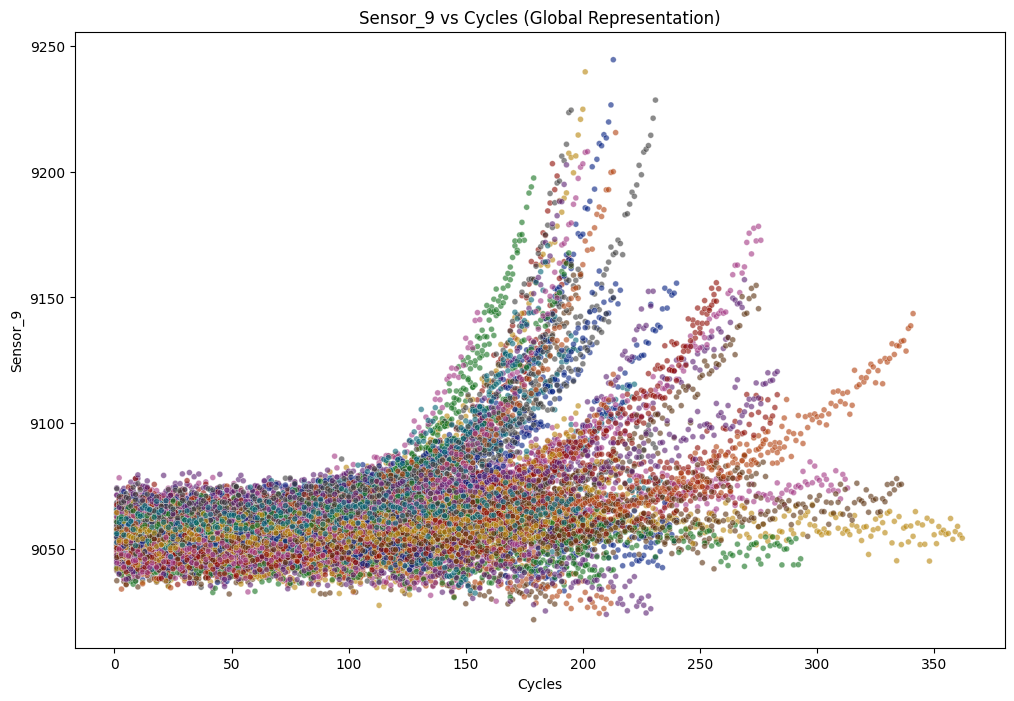

In [66]:
col = 'Sensor_9'
plt.figure(figsize=(12,8))
sns.scatterplot(data=dftrain, x='Cycles', y=col, hue='Engine', palette='dark',alpha=0.6, legend=False, size=12)
plt.title(f'{col} vs Cycles (Global Representation)')
plt.xlabel('Cycles')
plt.ylabel(col)
plt.show()

In [67]:
def plotSensors (df, title):
    fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(24, 40))
    fig.suptitle(f'Global Engine Readings for Each Sensor ({title})', fontsize=32)
    axes = axes.flatten()

    for i, sensor in enumerate(sensors):
        sns.scatterplot(data=df, x='Cycles', y=sensor, hue='Engine', palette='dark', marker='o', size=12, alpha=0.6, legend=False, ax=axes[i])
        axes[i].set_title(f'Cycles vs {sensor}', fontsize=14)  # Adjust subplot title font size
        axes[i].set_xlabel('Cycles', fontsize=12)
        axes[i].set_ylabel(sensor, fontsize=12)
        
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [68]:
#plotSensors(dftrain, title='Training Dataset')
#plotSensors(dftest, title='Test Dataset')

In [69]:
#cols = [col for col in dftr.columns if col not in ['Engine', 'Cycles']]
col = 'Sensor_6'

print(dftrain.groupby(col)['Engine'].nunique())
print('')
print(dftest.groupby(col)['Engine'].nunique())

Sensor_6
21.60     62
21.61    100
Name: Engine, dtype: int64

Sensor_6
21.60     66
21.61    100
Name: Engine, dtype: int64


In [70]:
dftrain.drop(columns=[col for col in dftrain.columns if dftrain[col].nunique() <= 2], inplace=True)
dftest.drop(columns=[col for col in dftest.columns if dftest[col].nunique() <= 2], inplace=True)

In [71]:
def plotHist (df, title):
    sensors = [col for col in df.columns if col not in ['Engine', 'Cycles']]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 18))
    fig.suptitle(f'Global Engine Histograms for Each Sensor ({title})', fontsize=32)
    axes = axes.flatten()

    for i, sensor in enumerate(sensors):
        sns.histplot(data=df, x=sensor, bins=50, color='seagreen', alpha=0.6, ax=axes[i])
        axes[i].set_title(f'{sensor} Histogram (Global)', fontsize=14)  # Adjust subplot title font size
        axes[i].set_xlabel(sensor, fontsize=12)
        #axes[i].set_ylabel('Count', fontsize=12)
        
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

#plotHist(dftrain, 'Training Dataset')
#plotHist(dftest, 'Test Dataset')

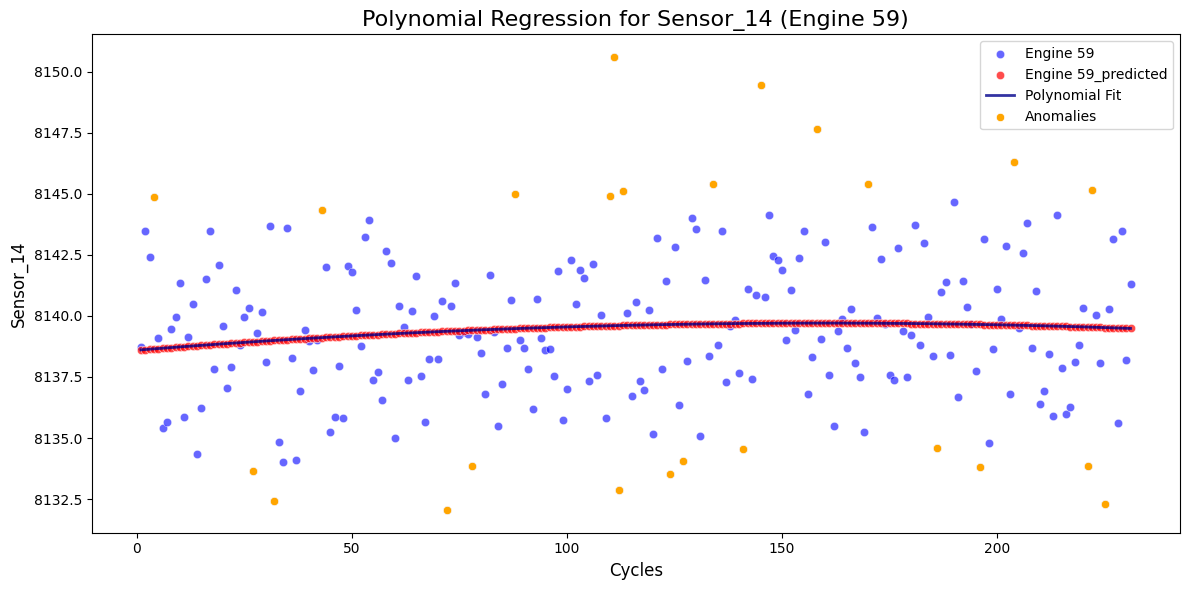

In [72]:
# Specify the engine ID to analyze
engine = 59  # Replace with the desired engine ID
sensor = 'Sensor_14'
poly_degree = 2

# Filter data for the specified engine
df_engine = dftrain.loc[dftrain['Engine'] == engine]

x = df_engine['Cycles']
y = df_engine[sensor]

# Fit polynomial regression
coefficients = np.polyfit(x, y, deg=poly_degree)
poly_func = np.poly1d(coefficients)

# Predict values
y_pred = poly_func(x)

# Calculate residuals (actual - predicted)
residuals = y - y_pred

# Define anomaly threshold (e.g., 2 standard deviations)
lower_b, upper_b = np.percentile(residuals, [5, 95])

# Identify anomalies
anomalies = df_engine[(residuals < lower_b) | (residuals > upper_b)]

# Plot results
plt.figure(figsize=(12, 6))
plt.title(f'Polynomial Regression for {sensor} (Engine {engine})', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel(sensor, fontsize=12)

# Scatter plot of actual data
sns.scatterplot(x=x, y=y, alpha=0.6, color='blue', label=f'Engine {engine}')
sns.scatterplot(x=x, y=y_pred, alpha=0.7, color='red', label=f'Engine {engine}_predicted')

# Polynomial regression line
x_sorted = np.sort(x)
plt.plot(x_sorted, poly_func(x_sorted), color='darkblue', linewidth=2, alpha=0.8, label='Polynomial Fit')

# Highlight anomalies
sns.scatterplot(data=anomalies, x='Cycles', y=sensor, color='orange', label='Anomalies', zorder=5)

# Add legend and show plot
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [73]:
'''
# Using sklearn polyfeatures
x1 = df_engine[['Cycles']].values
y1 = df_engine[sensor].values

poly = PolynomialFeatures(degree=poly_degree)
x_poly = poly.fit_transform(x1)

model_LR = LinearRegression()
model_LR.fit(x_poly, y1)
y_pred1 = model_LR.predict(x_poly)

residuals1 = y1 - y_pred1

lower_b1, upper_b1 = np.percentile(residuals, [5, 95])
anomalies1 = df_engine[(residuals1 < lower_b1) | (residuals1 > upper_b1)]

# Plot results
plt.figure(figsize=(12, 6))
plt.title(f'Polynomial Regression (ML) for {sensor} (Engine {engine})', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel(sensor, fontsize=12)

sns.scatterplot(data=df_engine, x=x1.flatten(), y=y1, alpha=0.6, color='blue', label=f'Engine {engine}')

x_sorted1 = np.sort(x1, axis=0)
y_sorted1 = model_LR.predict(poly.transform(x_sorted1))

plt.plot(x_sorted1, y_sorted1, color='darkblue', linewidth=2, alpha=0.8, label='Polynomial Fit')
sns.scatterplot(data=anomalies1, x='Cycles', y=sensor, color='orange', label='Anomalies', zorder=5)

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
'''

"\n# Using sklearn polyfeatures\nx1 = df_engine[['Cycles']].values\ny1 = df_engine[sensor].values\n\npoly = PolynomialFeatures(degree=poly_degree)\nx_poly = poly.fit_transform(x1)\n\nmodel_LR = LinearRegression()\nmodel_LR.fit(x_poly, y1)\ny_pred1 = model_LR.predict(x_poly)\n\nresiduals1 = y1 - y_pred1\n\nlower_b1, upper_b1 = np.percentile(residuals, [5, 95])\nanomalies1 = df_engine[(residuals1 < lower_b1) | (residuals1 > upper_b1)]\n\n# Plot results\nplt.figure(figsize=(12, 6))\nplt.title(f'Polynomial Regression (ML) for {sensor} (Engine {engine})', fontsize=16)\nplt.xlabel('Cycles', fontsize=12)\nplt.ylabel(sensor, fontsize=12)\n\nsns.scatterplot(data=df_engine, x=x1.flatten(), y=y1, alpha=0.6, color='blue', label=f'Engine {engine}')\n\nx_sorted1 = np.sort(x1, axis=0)\ny_sorted1 = model_LR.predict(poly.transform(x_sorted1))\n\nplt.plot(x_sorted1, y_sorted1, color='darkblue', linewidth=2, alpha=0.8, label='Polynomial Fit')\nsns.scatterplot(data=anomalies1, x='Cycles', y=sensor, color=

In [74]:
'''
# Moving Averages/Median method
method = 'mean'
window_size = 20

x = df_engine['Cycles']
y = df_engine[sensor]

# Calculate smoothed values
if method == 'mean':
    smoothed = y.rolling(window=min(window_size, len(y)), center=True).mean()
elif method == 'median':
    smoothed = y.rolling(window=min(window_size, len(y)), center=True).median()
else:
    raise ValueError("Invalid method. Use 'mean' or 'median'.")

# Drop NaNs and align indices
smoothed = smoothed.dropna()
x = x[smoothed.index]
y = y[smoothed.index]

# Calculate residuals
residuals = y - smoothed

# Validate residuals before calculating bounds
if not residuals.empty:
    lower_b, upper_b = np.percentile(residuals, [5, 95])
    # Align anomalies with original DataFrame index
    anomaly_indices = residuals[(residuals < lower_b) | (residuals > upper_b)].index
    anomalies = df_engine.loc[anomaly_indices]
else:
    print("Residuals contain no valid data for anomaly detection.")
    anomalies = pd.DataFrame()  # Empty anomalies DataFrame

# Plot the results
plt.figure(figsize=(12, 6))
plt.title(f'Anomaly Detection for {sensor} (Engine {engine})', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel(sensor, fontsize=12)

sns.scatterplot(x=x, y=y, color='blue', alpha=0.6, label=f'Engine {engine}')
plt.plot(x, smoothed, color='darkblue', linewidth=2, label='Smoothed (Moving Avg/Median)')
sns.scatterplot(data=anomalies, x='Cycles', y=sensor, color='orange', label='Anomalies', zorder=5)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
'''

'\n# Moving Averages/Median method\nmethod = \'mean\'\nwindow_size = 20\n\nx = df_engine[\'Cycles\']\ny = df_engine[sensor]\n\n# Calculate smoothed values\nif method == \'mean\':\n    smoothed = y.rolling(window=min(window_size, len(y)), center=True).mean()\nelif method == \'median\':\n    smoothed = y.rolling(window=min(window_size, len(y)), center=True).median()\nelse:\n    raise ValueError("Invalid method. Use \'mean\' or \'median\'.")\n\n# Drop NaNs and align indices\nsmoothed = smoothed.dropna()\nx = x[smoothed.index]\ny = y[smoothed.index]\n\n# Calculate residuals\nresiduals = y - smoothed\n\n# Validate residuals before calculating bounds\nif not residuals.empty:\n    lower_b, upper_b = np.percentile(residuals, [5, 95])\n    # Align anomalies with original DataFrame index\n    anomaly_indices = residuals[(residuals < lower_b) | (residuals > upper_b)].index\n    anomalies = df_engine.loc[anomaly_indices]\nelse:\n    print("Residuals contain no valid data for anomaly detection.")\n

In [75]:
# Function to replace anomalies in the input dataframe using the predicted values from its respective polynomial regression.
def anomaly_replacement_polyfunction(df):

    for engine in df['Engine'].unique():
        
        df_engine = df.loc[df['Engine'] == engine]
        sensors = [col for col in df_engine.columns if col not in ['Engine', 'Cycles', 'OpSet_2']]
        
        for sensor in sensors:
            # Independent and dependent variables
            x = df_engine['Cycles']
            y = df_engine[sensor]
            
            # Fit polynomial regression
            coefficients = np.polyfit(x, y, deg=2)
            poly_func = np.poly1d(coefficients)
            y_pred = poly_func(x)
            
            # Calculate residuals
            residuals = y - y_pred
            
            # Define lower and upper bounds using percentiles
            lower_b, upper_b = np.percentile(residuals, [5, 95])
            
            # Replace anomalies with predicted values
            anomalies_mask = (residuals < lower_b) | (residuals > upper_b)
            df.loc[df_engine.index[anomalies_mask], sensor] = y_pred[anomalies_mask]
    
    return df

In [76]:
dftrain = anomaly_replacement_polyfunction(dftrain)
dftest = anomaly_replacement_polyfunction(dftest)

C:\Users\Shahbaz\AppData\Local\Temp\ipykernel_29704\3151875341.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[392.10393408 391.88923699 391.87896523 391.87003708 391.88612184
 391.91670604 392.0355255  392.07100703 392.16555383 392.24316433
 392.54794946 392.78210744 393.16636017 393.72146296 394.05464146
 394.17174719 394.75821298 395.07613468 395.12289567 395.5090761 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_engine.index[anomalies_mask], sensor] = y_pred[anomalies_mask]
C:\Users\Shahbaz\AppData\Local\Temp\ipykernel_29704\3151875341.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[391.7205405  391.55697239 391.44615229 391.73740014]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_engine.index[anomali

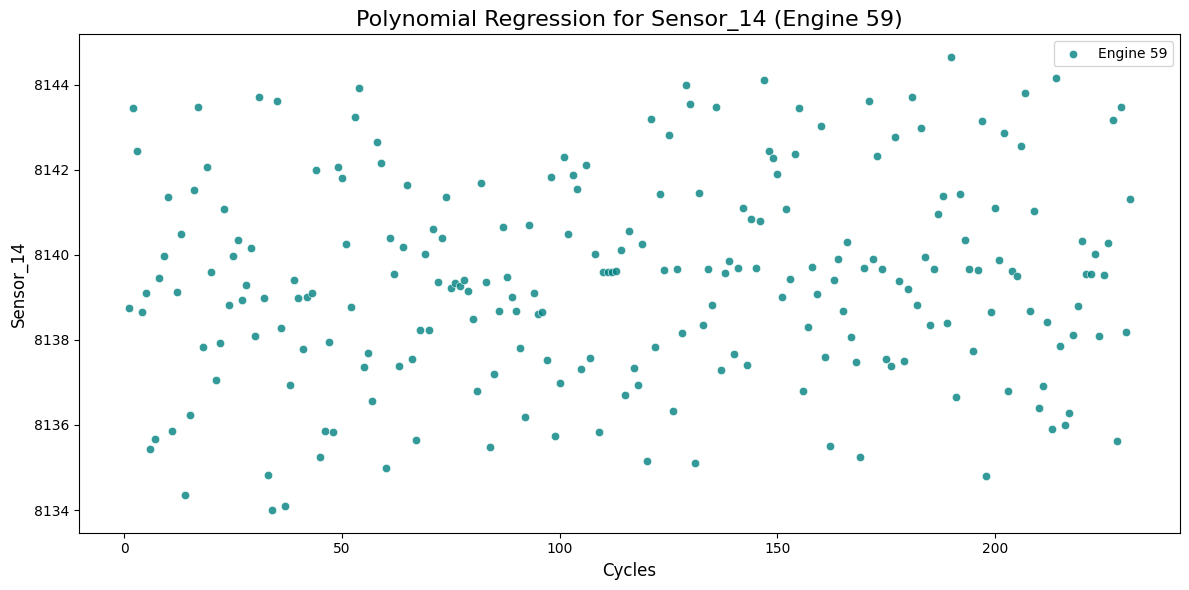

In [77]:
df_engine = dftrain.loc[dftrain['Engine'] == engine]

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_engine, x='Cycles', y=sensor, color='teal', alpha=0.8, label=f'Engine {engine}')
plt.title(f'Polynomial Regression for {sensor} (Engine {engine})', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel(sensor, fontsize=12)

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [78]:
print((dftrain['OpSet_2'].value_counts().sort_index()))

OpSet_2
-0.0006      34
-0.0005     958
-0.0004    2051
-0.0003    2104
-0.0002    2049
-0.0001    2029
 0.0000    2070
 0.0001    2097
 0.0002    2038
 0.0003    2065
 0.0004    1997
 0.0005    1068
 0.0006      71
Name: count, dtype: int64


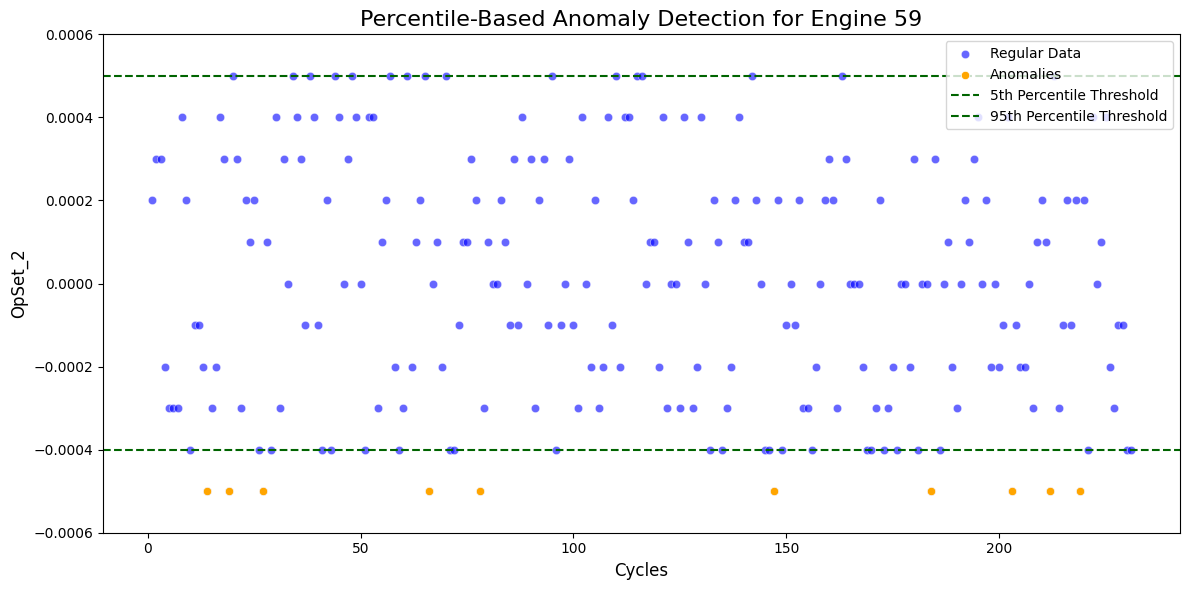

In [79]:
engine = 59
df_engine = dftrain.loc[dftrain['Engine'] == engine]

lower_bound, upper_bound = np.percentile(df_engine['OpSet_2'], [5,95])
anomalies = df_engine[(df_engine['OpSet_2'] < lower_bound) | (df_engine['OpSet_2'] > upper_bound)]

plt.figure(figsize=(12, 6))
plt.title(f'Percentile-Based Anomaly Detection for Engine {engine}', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel('OpSet_2', fontsize=12)
plt.ylim(-0.0006,0.0006)

sns.scatterplot(data=df_engine, x='Cycles', y='OpSet_2', color='blue', alpha=0.6, label='Regular Data')
sns.scatterplot(data=anomalies, x='Cycles', y='OpSet_2', color='orange', label='Anomalies', zorder=5)
plt.axhline(lower_bound, color='darkgreen', linestyle='--', label='5th Percentile Threshold')
plt.axhline(upper_bound, color='darkgreen', linestyle='--', label='95th Percentile Threshold')

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [80]:
def anomaly_replacement_bounds(df):
    
    for engine in df['Engine'].unique():
        # Filter data for the current engine
        df_engine = df.loc[df['Engine'] == engine]
        
        # Compute the percentile boundaries
        y = df_engine['OpSet_2']
        lower_b, upper_b = np.percentile(y, [5, 95])
        
        # Identify and replace anomalies
        df.loc[df_engine.index, 'OpSet_2'] = np.where(y < lower_b, lower_b, np.where(y > upper_b, upper_b, y))
    
    return df

In [81]:
#dftrain = anomaly_replacement_bounds(dftrain)
#dftest = anomaly_replacement_bounds(dftest)

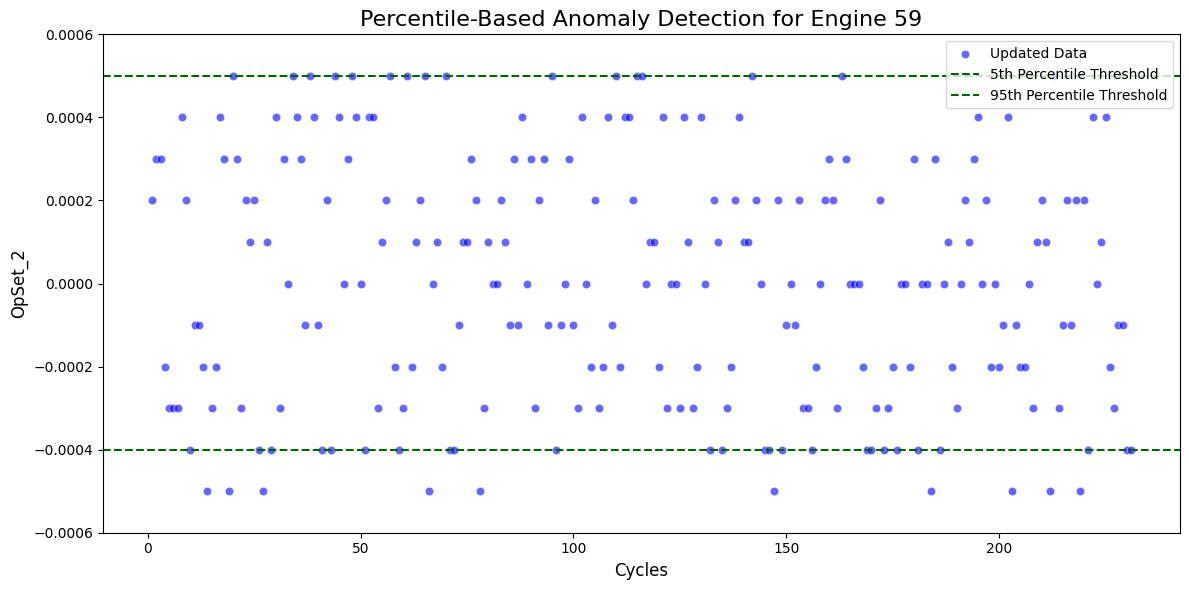

In [82]:
engine = 59
df_engine = dftrain.loc[dftrain['Engine'] == engine]

plt.figure(figsize=(12, 6))
plt.title(f'Percentile-Based Anomaly Detection for Engine {engine}', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel('OpSet_2', fontsize=12)
plt.ylim(-0.0006,0.0006)

sns.scatterplot(data=df_engine, x='Cycles', y='OpSet_2', color='blue', alpha=0.6, label='Updated Data')
plt.axhline(lower_bound, color='darkgreen', linestyle='--', label='5th Percentile Threshold')
plt.axhline(upper_bound, color='darkgreen', linestyle='--', label='95th Percentile Threshold')

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [83]:
def log_transform (df, threshold):
        
    for engine in df['Engine'].unique():
        
        df_engine = df.loc[df['Engine'] == engine]
        skewness = df_engine.skew()
        skewed = skewness[abs(skewness) > threshold].index.tolist()
        
        for sensor in skewed:
            df.loc[df['Engine'] == engine, sensor] = np.log1p(df_engine[sensor])
            
    return df

In [84]:
#dftrain = log_transform(dftrain, threshold=1)
#dftest = log_transform(dftrain, threshold=1)

In [85]:
cycles_max = dftrain.groupby(['Engine'], as_index=False)['Cycles'].max()

for engine in cycles_max['Engine']:
    dftrain.loc[dftrain['Engine'] == engine, 'RUL'] = cycles_max.loc[cycles_max['Engine'] == engine, 'Cycles'].values[0] - dftrain.loc[dftrain['Engine'] == engine, 'Cycles']

dftrain['RUL'] = dftrain['RUL'].astype('int64')

In [86]:
def scale (df, standard):
    cols = [col for col in df.columns if col not in ['Engine', 'Cycles', 'RUL']]
    
    if standard == True:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
        
    df[cols] = scaler.fit_transform(df[cols])
    return df

In [87]:
dftrain = scale(dftrain, True)
dftest = scale(dftest, True)

In [88]:
dftrain = pd.get_dummies(data=dftrain, columns=['Engine'], drop_first=False, dtype=int)
dftest = pd.get_dummies(data=dftest, columns=['Engine'], drop_first=False, dtype=int)

In [89]:
RF = RandomForestRegressor(random_state=None, n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=None)
x_train = dftrain.drop(columns=['RUL'])
ytrain = dftrain['RUL']

x_test = dftest
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

RF.fit(x_train, ytrain)
ruls = RF.predict(x_test).round().astype(int)
print(len(ruls))

13096


In [90]:
engines = [col for col in dftest if col.startswith('Engine_')]
dftest_engine = pd.from_dummies(dftest[engines], sep='_').astype(int)
dftest_engine['RUL'] = ruls
df_rul = dftest_engine.groupby(['Engine'], as_index=False)['RUL'].last()
df_rul = df_rul.sort_values(by='Engine').reset_index(drop=True)
df_rul

,Engine,RUL
0,1,162
1,2,117
2,3,28
3,4,46
4,5,63
...,...,...
95,96,154
96,97,54
97,98,43
98,99,93


In [91]:
dfr

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [92]:
rul_pred = df_rul['RUL'].values
rul_true = dfr['RUL'].values

mse = mean_squared_error(rul_true, rul_pred)
rmse = root_mean_squared_error(rul_true, rul_pred)
mae = mean_absolute_error(rul_true, rul_pred)
r2 = r2_score(rul_true, rul_pred)

print('--'*10 + ' RandomForest Regressor ' + '--'*10 + '\n')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

-------------------- RandomForest Regressor --------------------

Mean Squared Error (MSE): 1035.39
Root Mean Squared Error (RMSE): 32.17747659466168
Mean Absolute Error (MAE): 25.35
R^2 Score: 0.40042374942497094


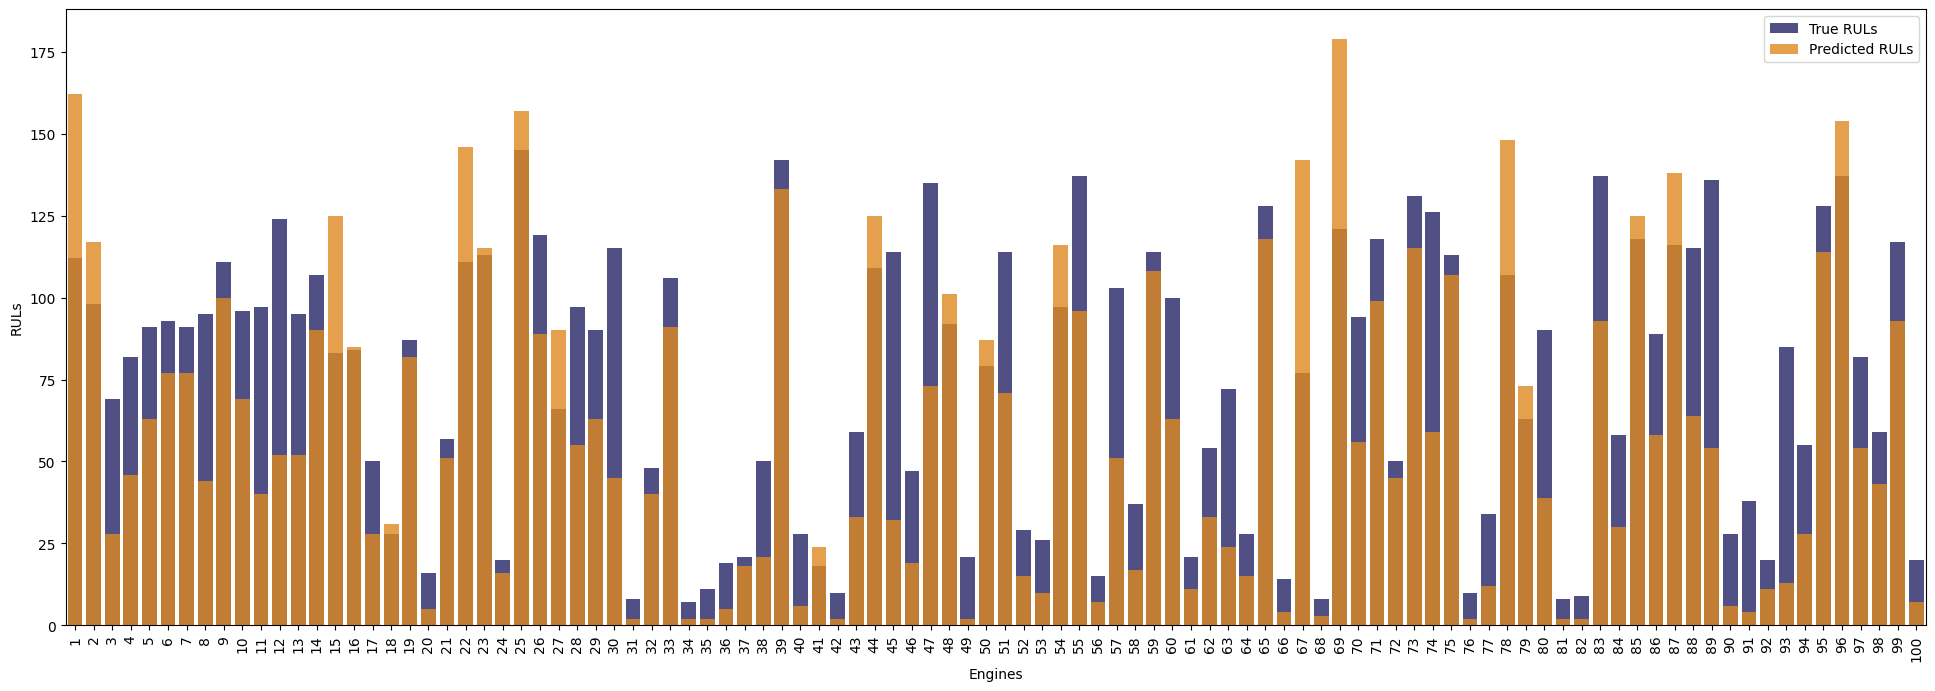

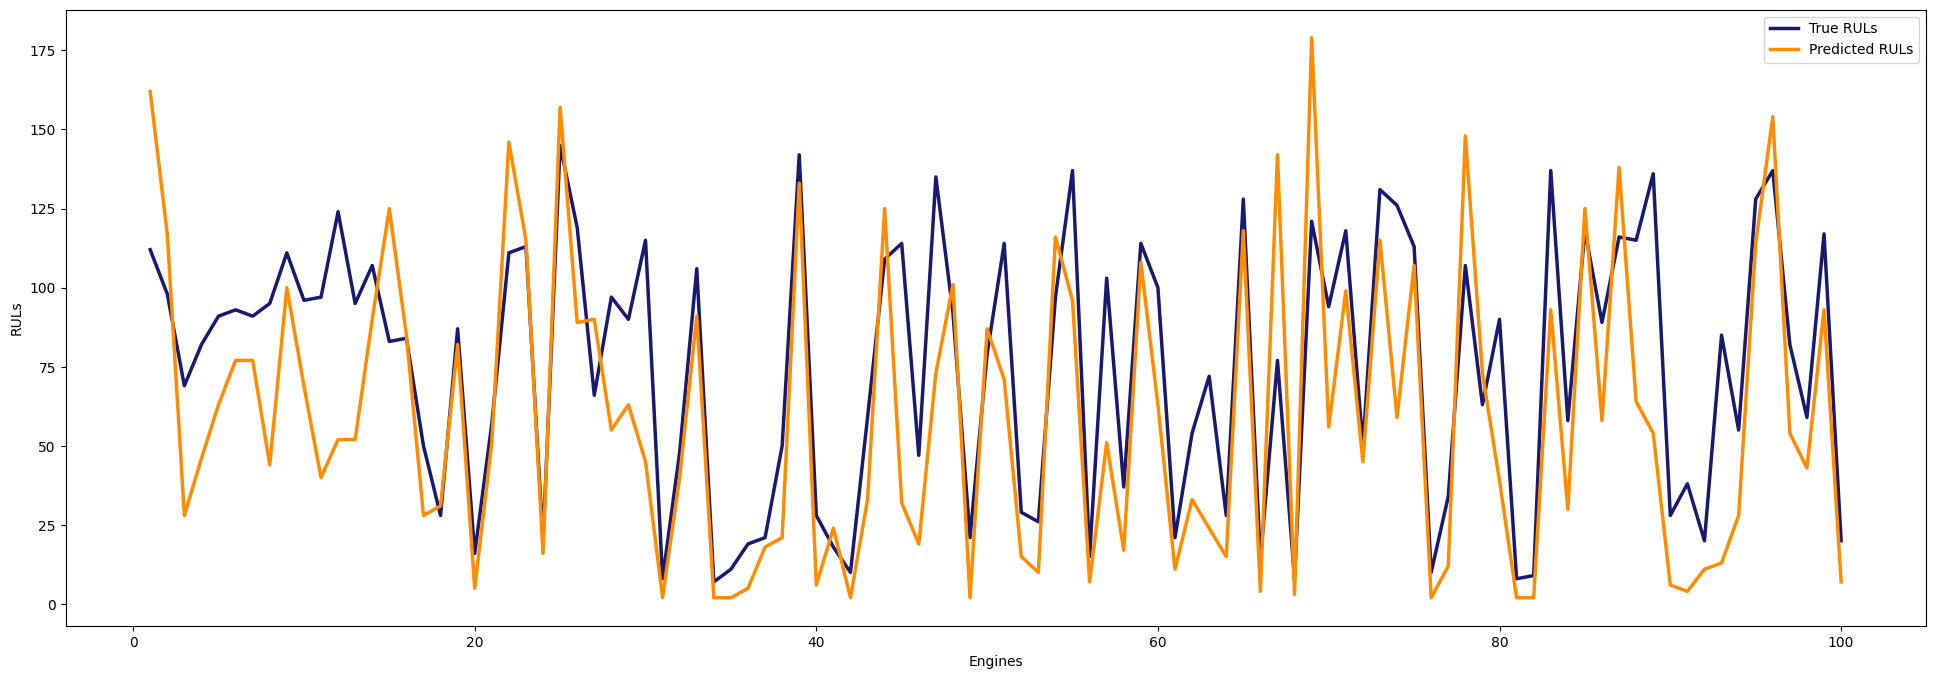

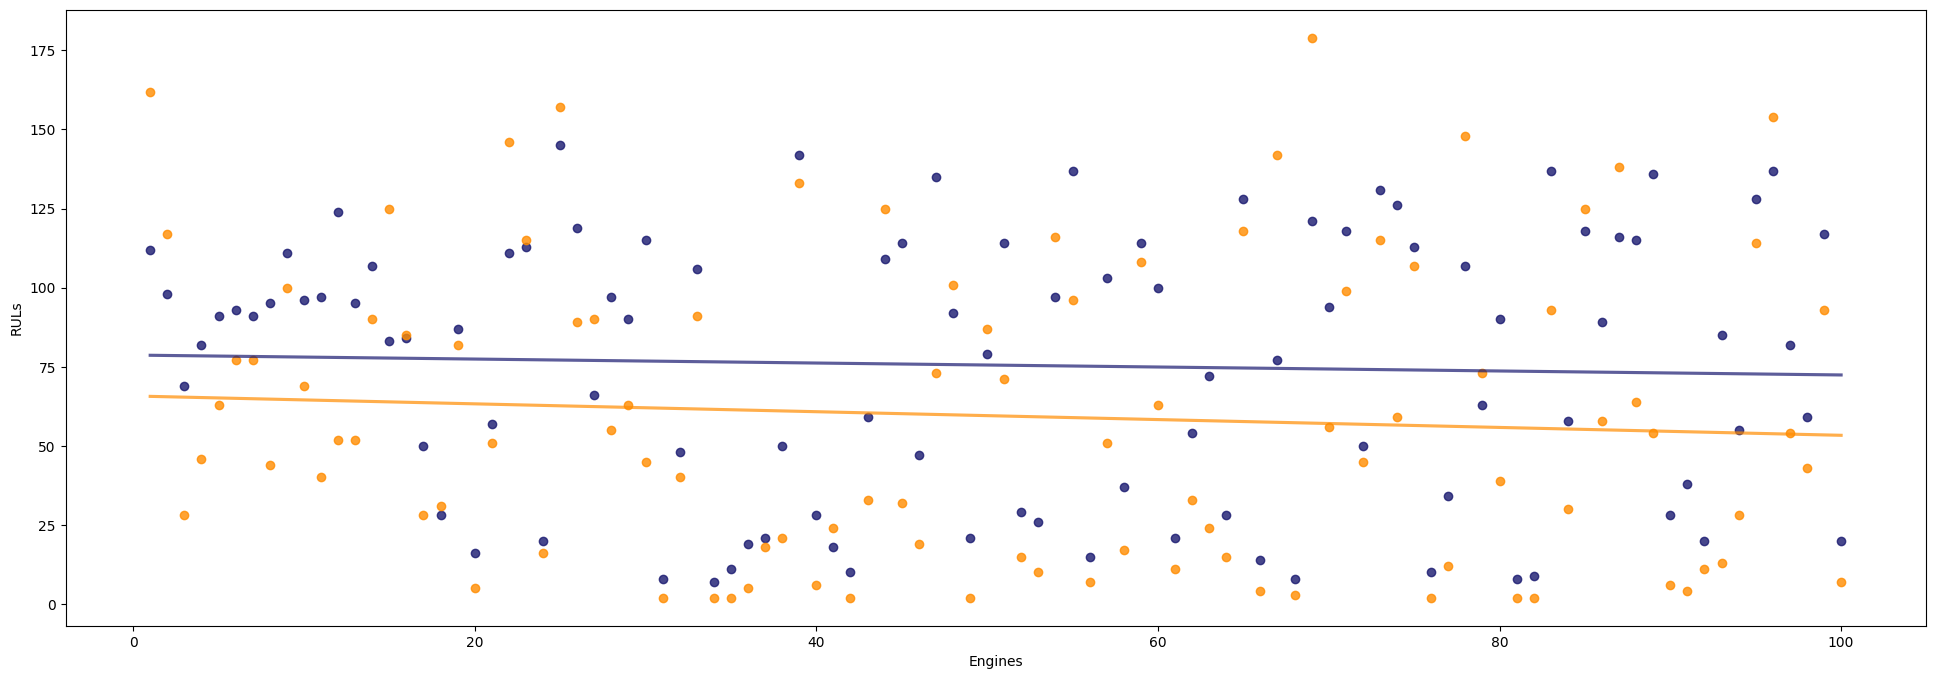

In [93]:
dfr.index = dfr.index + 1
df_rul.index = df_rul.index + 1

plt.figure(figsize=(24,8))
sns.barplot(x=dfr.index.values, y=rul_true, color='midnightblue', alpha=0.8, label='True RULs')  
sns.barplot(x=df_rul.index.values, y=rul_pred, color='darkorange', alpha=0.8, label='Predicted RULs')  
plt.xlabel('Engines')
plt.xticks(rotation=90)
plt.ylabel('RULs')
plt.show()

plt.figure(figsize=(24,8))
sns.lineplot(x=dfr.index.values, y=rul_true, color='midnightblue', label='True RULs', linewidth=2.5)
sns.lineplot(x=df_rul.index.values, y=rul_pred, color='darkorange', label='Predicted RULs', linewidth=2.5)
plt.xlabel('Engines')
plt.ylabel('RULs')
plt.show()

plt.figure(figsize=(24,8))
sns.regplot(x=dfr.index.values, y=rul_true, scatter_kws={'color': 'midnightblue', 'label': 'True RULs'}, line_kws={'color': 'midnightblue', 'alpha': 0.7}, ci=None)
sns.regplot(x=df_rul.index.values, y=rul_pred, scatter_kws={'color': 'darkorange', 'label': 'Predicted RULs'}, line_kws={'color': 'darkorange', 'alpha': 0.7}, ci=None)
plt.xlabel('Engines')
plt.ylabel('RULs')
plt.show()